# Solvent-Environment Dependence of the Excess Chemical Potential and its Computation Scheme Formulated Though Error Minimization: <br>*Determination of octanol-water partitioning free energy*
Stefan Hervø-Hansen<sup>a</sup>, Kazuya Okita<sup>a</sup>, Kento Kasahara<sup>a</sup>, and Nobuyuki Matubayasi<sup>a,</sup><br><br>
<sup>a</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup></sup> Correspondence may be addressed to: stefan@cheng.es.osaka-u.ac.jp and nobuyuki@cheng.es.osaka-u.ac.jp.


## Part 2: Determination of Performance of Solute-Only BAR method

## Import of Python Modules & Auxiliary Functions

In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy import optimize
from sklearn.decomposition import PCA
import mdtraj as md
from uncertainties import unumpy, ufloat, umath
import parmed as pmd

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#e69f00", "#56b4e9", "#009e73"])
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams["text.usetex"] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

from Auxiliary import fessa
plt.set_cmap('fessa')

kJ_to_kcal = 0.239

homedir = !pwd
homedir = homedir[0]
workdir = '/home/users/eau/Octanol-Water_partitioning' # RCCS
print(homedir)

/data/group1/z44785r/Octanol-Water_partitioning


<Figure size 640x480 with 0 Axes>

In [2]:
def get_2D_PMF(xall, yall, weights=None, nbins=50, avoid_zero_count=True, minener_zero=True, kT=1.0, ranges=None):
    """Free energy plot given 2D scattered data.
Builds a 2D-histogram of the given data points and plots -log(p) where p is
the probability computed from the histogram count.
Parameters
----------
xall : ndarray(T)
    sample x-coordinates
yall : ndarray(T)
    sample y-coordinates
weights : ndarray(T), default = None
    sample weights. By default all samples have the same weight
nbins : int, default=100
    number of histogram bins used in each dimension
avoid_zero_count : bool, default=True
    avoid zero counts by lifting all histogram elements to the minimum value
    before computing the free energy. If False, zero histogram counts will
    yield NaNs in the free energy which and thus regions that are not plotted.
minener_zero : bool, default=True
    Shifts the energy minimum to zero. If false, will not shift at all.
kT : float, default=1.0
    The value of kT in the desired energy unit. By default, will compute
    energies in kT (setting 1.0). If you want to measure the energy in
    kJ/mol at 298 K, use kT=2.479 and change the cbar_label accordingly.
ranges : tuple
    The extend the 2d histogram should be compute. The tuple should 
    have the form ((xmin, xmax), (ymin, ymax)).
Returns
-------
(x,y,F)
"""
    # histogram
    z, xedge, yedge = np.histogram2d(xall, yall, bins=nbins, weights=weights, range=ranges)
    x = 0.5*(xedge[:-1] + xedge[1:])
    y = 0.5*(yedge[:-1] + yedge[1:])
    # avoid zeros
    if avoid_zero_count:
        zmin_nonzero = np.min(z[np.where(z > 0)])
        z = np.maximum(z, zmin_nonzero)
    # compute free energies
    F = -kT * np.log(z)
    if minener_zero:
        F -= np.min(F)

    return (x,y,F.T)

In [3]:
RT = 0.00831446261815324 * 298.15 # [kJ/mol]

def BAR_solvation_free_energy(D, state_A, state_B, T=298.15, R=0.00831446261815324):
    RT = R * T
    
    # Asign two states
    dSLVFE_AB = state_A[1] - state_A[0]
    dSLVFE_BA = -(state_B[1] - state_B[0])
    
    # Initializing sum of Fermi-Dirac functions
    sum_f_ij = 0
    sum_f_ji = 0
    
    # Adding Fermi-Dirac function for each slvfe
    for dSLVFE in dSLVFE_AB:
        sum_f_ij += 1/(1+np.exp(-dSLVFE/RT+D))
    for dSLVFE in dSLVFE_BA:
        sum_f_ji += 1/(1+np.exp(dSLVFE/RT-D))
        
    # return squared diff. btw sums of Fermi-Dirac functions
    return (sum_f_ij - sum_f_ji)**2

def BAR_error_solvation_free_energy(D, state_A, state_B, state_A_errs, state_B_errs, T=298.15, R=0.00831446261815324):
    RT = R * T
    
    def F(x): # Fermi-Dirac function
        return 1/(1+np.exp(x))
    def FF(x): # Eq. 21
        return -(1/RT)*F(x)*F(-x)
    
    # Asign two states (Propagation of errors)
    dSLVFE_AB = unumpy.uarray(state_A[1], state_A_errs[1]) - unumpy.uarray(state_A[0], state_A_errs[0])
    dSLVFE_BA = -(unumpy.uarray(state_B[1], state_B_errs[1]) - unumpy.uarray(state_B[0], state_B_errs[0]))
    
    # Calculate the denominator and store the nominators of Eq. 20 
    nominators = []
    denominator = 0
    for slvfe in [*unumpy.nominal_values(dSLVFE_AB), *unumpy.nominal_values(dSLVFE_BA)]:
        value = FF(D-slvfe)
        denominator += value
        nominators.append(value)
        
    # Summuation of the error (Eq. 19)
    BAR_error = 0
    for C, slvfe_err in zip(nominators, [*unumpy.std_devs(dSLVFE_AB), *unumpy.std_devs(dSLVFE_BA)]):
        BAR_error+= (C/denominator)**2 * slvfe_err**2
    return float(np.sqrt(BAR_error))

## Simulation settings

In [4]:
# Alchemical pathway
lambdas = {
    1: {'sterics': 0.0, 'electrostatics': 0.0},
    2: {'sterics': 0.1, 'electrostatics': 0.0},
    3: {'sterics': 0.2, 'electrostatics': 0.0},
    4: {'sterics': 0.3, 'electrostatics': 0.0},
    5: {'sterics': 0.4, 'electrostatics': 0.0},
    6: {'sterics': 0.5, 'electrostatics': 0.0},
    7: {'sterics': 0.6, 'electrostatics': 0.0},
    8: {'sterics': 0.7, 'electrostatics': 0.0},
    9: {'sterics': 0.8, 'electrostatics': 0.0},
   10: {'sterics': 0.9, 'electrostatics': 0.0},
   11: {'sterics': 1.0, 'electrostatics': 0.0},
   12: {'sterics': 1.0, 'electrostatics': 0.2},
   13: {'sterics': 1.0, 'electrostatics': 0.4},
   14: {'sterics': 1.0, 'electrostatics': 0.6},
   15: {'sterics': 1.0, 'electrostatics': 0.8},
   16: {'sterics': 1.0, 'electrostatics': 1.0},
}

#*# SIMULATION SETTINGS #*#

# Conformational sampling #
#Nsteps = 50000000         # 100 ns
#OutFreq_conf = 5000       # 10.000 frames
#
## Free energy claculations #
NConfs_sim = 20
## Total simulation time = outFreq x NumAlchemicalSnapshots x dt             [500 x 25000 x 2 fs = 25 ns]
#NumAlchemicalSnapshots = 25000 # Number of Alchemical energies computed
#outFreq = 500 # Output frequence

# analysis
NConfs = 20
max_time = 10 # ns
Conf_order = [0,10,1,11,2,12,3,13,4,14,5,15,6,16,7,17,8,18,9,19]

# Generate files for running MD simulations?
PERFORM_CONFORMATIONAL_SIMULATIONS = False
PERFORM_FREE_ENERGY_SIMULATIONS = False

## Step 1: Generate Conformational Ensemble
### Generation of Initial Configuration and Topology

In [5]:
%cd -q $homedir

if PERFORM_CONFORMATIONAL_SIMULATIONS: 
    # Water
    %cd -q $homedir/Simulations/Solute-Only_BAR/Water/Solute
    %mkdir min
    %cp $homedir/PDB_files/Hexanol_in_water.gro min/init.gro
    %cp $homedir/Force_fields/OPLS-AA-1.14_CM1A-LBCC_GROMACS/Hexanol_in_water.top .
    
    
    # Octanol
    %cd -q $homedir/Simulations/Solute-Only_BAR/1-Octanol/Solute
    %mkdir min
    %cp $homedir/PDB_files/Hexanol_in_octanol.gro min/init.gro
    %cp $homedir/Force_fields/OPLS-AA-1.14_CM1A-LBCC_GROMACS/Hexanol_in_octanol.top .   

### Generation of mdp Files

In [6]:
%cd -q $homedir

GROMACS_mdp_min="""
; Run control
integrator               = steep 
nsteps                   = 5000
; EM criteria and other stuff
emtol                    = 100
emstep                   = 0.01
niter                    = 20
nbfgscorr                = 10
; Output control
nstlog                   = 1
nstenergy                = 1
; Neighborsearching and short-range nonbonded interactions
cutoff-scheme            = verlet
nstlist                  = 1
pbc                      = xyz
rlist                    = 1.2
; Electrostatics
coulombtype              = PME
rcoulomb                 = 1.2
; van der Waals
vdwtype = switch
rvdw            = 1.2
rvdw_switch = 1.0
DispCorr        = No
; Spacing for the PME/PPPM FFT grid
fourierspacing           = 0.12
; EWALD/PME/PPPM parameters
pme_order                = 6
ewald_rtol               = 1e-06
epsilon_surface          = 0
; Temperature and pressure coupling are off during EM
tcoupl                   = no
pcoupl                   = no
; Bond parameters
constraint_algorithm    = lincs
constraints             = h-bonds
continuation            = no
{waterfix}define = -DFLEXIBLE 
"""

GROMACS_mdp_eq="""
; RUN CONTROL PARAMETERS
; Run parameters
integrator  = sd
dt          = 0.002
tinit       = 0
nsteps      = 5000000   ; 10 ns
; Output parameters
nstxout-compressed  = 500  ; 1 ps
nstenergy           = 500  ; 1 ps
; Bond parameters
constraint_algorithm    = lincs
constraints             = h-bonds
continuation            = no
; Single-range cutoff scheme
cutoff-scheme   = Verlet
nstlist         = 20 
;verlet-buffer-tolerance = 0.0001
rcoulomb        = 1.2
; van der Waals
vdwtype = switch
rvdw            = 1.2
rvdw_switch = 1.0
DispCorr        = No
; PME electrostatics parameters
coulombtype     = PME
fourierspacing  = 0.12
pme_order       = 4
ewald_rtol      = 1e-5
; Temperature coupling is on in two groups
tc-grps         = system
tau-t           = 1.0
ref-t           = 298.15
; Pressure coupling is off
Pcoupl          = No 
; Generate velocities is on
gen_vel     = yes 
; Periodic boundary conditions are on in all directions
pbc     = xyz
"""

GROMACS_mdp_production="""
; RUN CONTROL PARAMETERS
; Run parameters
integrator  = sd
dt          = 0.002
tinit       = 0
nsteps      = 50000000   ; 100 ns
; Output parameters
nstxout-compressed  = 500  ; 1 ps
nstenergy           = 500  ; 1 ps
; Bond parameters
constraint_algorithm    = lincs
constraints             = h-bonds
continuation            = yes
; Single-range cutoff scheme
cutoff-scheme   = Verlet
nstlist         = 20 
;verlet-buffer-tolerance = 0.0001
rcoulomb        = 1.2
; van der Waals
vdwtype = switch
rvdw            = 1.2
rvdw_switch = 1.0
DispCorr        = No
; PME electrostatics parameters
coulombtype     = PME
fourierspacing  = 0.12
pme_order       = 4
ewald_rtol      = 1e-5
; Temperature coupling is on in two groups
tc-grps         = system
tau-t           = 1.0
ref-t           = 298.15
; Pressure coupling is off
Pcoupl          = No 
; Generate velocities is off
gen_vel     = no 
; Periodic boundary conditions are on in all directions
pbc     = xyz
"""          

N_simulations = 0
if PERFORM_CONFORMATIONAL_SIMULATIONS:
    for solute in ['Water', '1-Octanol']:
        %cd -q $homedir/Simulations/Solute-Only_BAR/$solute/Solute
        
        if solute == 'Water':
            waterfix = ''
        else:
            waterfix = ';'
        
        with open('min/min.mdp', 'w') as f:
            f.write(GROMACS_mdp_min.format(waterfix=waterfix))
        f.close()
        
        %mkdir eq
        with open('eq/eq.mdp', 'w') as f:
            f.write(GROMACS_mdp_eq.format())
        f.close()
        
        with open('BAR.mdp', 'w') as f:
            f.write(GROMACS_mdp_production.format())
        f.close()
        
        print('Wrote mdp files to '+os.getcwd())
        N_simulations+=1
        
    print('Simulations about to be submitted: {}'.format(N_simulations))

### Generation of Submit Script

In [7]:
%cd -q $homedir

submit_script="""#!/bin/bash
## RCCS
#PBS -l select=1:ncpus=16:mpiprocs=1:ompthreads=16:jobtype=gpu:ngpus=1
#PBS -l walltime=24:00:00
#PBS -N Conf_{solvent}
#PBS -e run.err
#PBS -o run.out

cd {path}

source ~/.bashrc
source ~/.bash_profile

module purge
module load gromacs/2024.2-CUDA

# Minimization
cd min
gmx grompp -f min.mdp -p ../{topfile} -c init.gro -o min.tpr
gmx mdrun -deffnm min -ntmpi 1

# Equilibration
cd ../eq
gmx grompp -f eq.mdp -p ../{topfile} -c ../min/min.gro -o eq.tpr
gmx mdrun -deffnm eq -ntmpi 1

# Production
cd ..
gmx grompp -f BAR.mdp -p {topfile} -c eq/eq.gro -o BAR.tpr
gmx mdrun -deffnm BAR -ntmpi 1
"""

master_submit_script="""#!/bin/bash
read -p "Will submit {N_simulations} simulations. Do you want to proceed? (yes/no) " yn

case $yn in 
    yes ) echo submitting...;;
    no ) echo exiting...;
         exit;;
    * ) echo invalid response;
        exit 1;;
esac

"""
if PERFORM_CONFORMATIONAL_SIMULATIONS:
    with open('Simulations/Solute-Only_BAR/master_solute.sh', 'w') as ff:
        ff.write(master_submit_script.format(N_simulations=N_simulations))
        
        for solvent in ['Water', '1-Octanol']:
            %cd -q $homedir/Simulations/Solute-Only_BAR/$solvent/Solute
            
            if solvent == 'Water':
                topfile = 'Hexanol_in_water.top'
            if solvent == '1-Octanol':
                topfile = 'Hexanol_in_octanol.top'
            
            simpath = os.getcwd()
            simpath = simpath.split(sep='Octanol-Water_partitioning')[1]
            simpath = workdir+simpath
            with open('submit.pbs', 'w') as f:
                f.write(submit_script.format(path=simpath, topfile=topfile, solvent=solvent))
            f.close()
            s =  'cd {}\njsub submit.pbs\n\n'.format(simpath) # RCCS
            ff.write(s)
                    
    ff.close()

## Step 2: Compute Solvation Free Energies for Fixed Structures
### Generation of Initial Configuration and Topology

In [8]:
%cd -q $homedir

packmol_script="""
tolerance {tolerance}
filetype pdb
output init.pdb
pbc {box_size} {box_size} {box_size}

structure conf.pdb
        number 1
        center
        fixed {pos}. {pos}. {pos}. 0. 0. 0.
end structure

structure {homedir}/PDB_files/{solvent}.pdb
        number {N_solvent}
end structure
"""

if PERFORM_FREE_ENERGY_SIMULATIONS:
    for solvent in ['Water', '1-Octanol']:
        %cd -q $homedir/Simulations/Solute-Only_BAR/$solvent
        if solvent == 'Water':
            topfile = homedir+'/PDB_files/Hexanol_in_water.pdb'
        elif solvent == '1-Octanol':
            topfile = homedir+'/PDB_files/Hexanol_in_octanol.pdb'
        traj = md.load('Solute/BAR.xtc', top=topfile)
        hexanol = traj.topology.select('resname "HEX"')
        traj.image_molecules(inplace=True, make_whole=True, anchor_molecules=[set(traj.topology.residue(0).atoms)])
        traj.atom_slice(hexanol, inplace=True)
        traj = traj[1:][::traj.n_frames//(NConfs_sim)]
        assert len(traj) == NConfs_sim, 'The number of frames loaded is inconsistant with the number of desired conformations'
        
        for state in ['P_Water', 'P_1-Octanol']:
            for conf in range(NConfs_sim):
                %cd -q $homedir/Simulations/Solute-Only_BAR/$solvent/$state/$conf
                traj[conf].save('conf.pdb')
                
                if state == 'P_Water':
                    with open('packmol.in', 'w') as f:
                        f.write(packmol_script.format(homedir=homedir, solvent='water', N_solvent=2000,
                                                      box_size=39.40, pos=19.70, tolerance=2.0))
                    f.close()
                    !/home/z44785r/packmol-20.15.1/packmol < packmol.in
                    mol = pmd.load_file(homedir+'/Force_fields/OPLS-AA-1.14_CM1A-LBCC_GROMACS/Hexanol_in_water.top', xyz='init.pdb')
                    mol.save('init.gro', overwrite=True)
                
                elif state == 'P_1-Octanol':
                    with open('packmol.in', 'w') as f:
                        f.write(packmol_script.format(homedir=homedir, solvent='1-octanol', N_solvent=500,
                                                      box_size=51.06, pos=25.53, tolerance=1.0))
                    f.close()
                    !/home/z44785r/packmol-20.15.1/packmol < packmol.in
                    mol = pmd.load_file(homedir+'/Force_fields/OPLS-AA-1.14_CM1A-LBCC_GROMACS/Hexanol_in_octanol.top', xyz='init.pdb')
                    mol.save('init.gro', overwrite=True)

### Generation of mdp Files

In [9]:
%cd -q $homedir

GROMACS_mdp_min="""
; Run control
integrator               = steep 
nsteps                   = 5000
; EM criteria and other stuff
emtol                    = 100
emstep                   = 0.01
niter                    = 20
nbfgscorr                = 10
; Freeze particles
freezegrps = HEX {solvent}
freezedim = Y Y Y N N N
; Output control
nstlog                   = 1
nstenergy                = 1
; Neighborsearching and short-range nonbonded interactions
cutoff-scheme            = verlet
nstlist                  = 1
pbc                      = xyz
rlist                    = 1.2
; Electrostatics
coulombtype              = PME
rcoulomb                 = 1.2
; van der Waals
vdwtype = switch
rvdw            = 1.2
rvdw_switch = 1.0
DispCorr        = No
; Spacing for the PME/PPPM FFT grid
fourierspacing           = 0.12
; EWALD/PME/PPPM parameters
pme_order                = 6
ewald_rtol               = 1e-06
epsilon_surface          = 0
; Temperature and pressure coupling are off during EM
tcoupl                   = no
pcoupl                   = no
; Bond parameters
constraint_algorithm    = lincs
constraints             = h-bonds
continuation            = no
{waterfix}define = -DFLEXIBLE 

; Free energy variables
free-energy                 = yes
nstdhdl                     = 500
couple-moltype              = HEX
couple-lambda0              = none
couple-lambda1              = vdw-q
couple-intramol             = no
init-lambda-state           = {default_lambda}
delta-lambda                = 0
vdw_lambdas                 = 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.0 1.0 1.0 1.0 1.0
coul_lambdas                = 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.4 0.6 0.8 1.0
calc-lambda-neighbors       = 1
dhdl-print-energy           = no
sc-function                 = beutler
sc-alpha                    = 0.5
sc-power                    = 1
sc-r-power                  = 6
sc-sigma                    = 0.3
sc-coul                     = no
sc-gapsys-scale-linpoint-lj = 0.85
sc-gapsys-scale-linpoint-q  = 0.3
sc-gapsys-sigma-lj          = 0.3
separate-dhdl-file          = no
dhdl-derivatives            = no
dh_hist_size                = 0
dh_hist_spacing             = 0.1
"""

GROMACS_mdp_eq="""
; RUN CONTROL PARAMETERS
; Run parameters
integrator  = sd
dt          = 0.002
tinit       = 0
nsteps      = 5000000   ; 10 ns
; Freeze particles
freezegrps = HEX {solvent}
freezedim = Y Y Y N N N
; Output parameters
nstxout-compressed  = 500  ; 1 ps
nstenergy           = 500  ; 1 ps
; Bond parameters
constraint_algorithm    = lincs
constraints             = h-bonds
continuation            = no
; Single-range cutoff scheme
cutoff-scheme   = Verlet
nstlist         = 20 
;verlet-buffer-tolerance = 0.0001
rcoulomb        = 1.2
; van der Waals
vdwtype = switch
rvdw            = 1.2
rvdw_switch = 1.0
DispCorr        = No
; PME electrostatics parameters
coulombtype     = PME
fourierspacing  = 0.12
pme_order       = 4
ewald_rtol      = 1e-5
; Temperature coupling is on in two groups
tc-grps         = system
tau-t           = 1.0
ref-t           = 298.15
; Pressure coupling is off
Pcoupl          = No 
; Generate velocities is on
gen_vel     = yes 
; Periodic boundary conditions are on in all directions
pbc     = xyz

; Free energy variables
free-energy                 = yes
nstdhdl                     = 500
couple-moltype              = HEX
couple-lambda0              = none
couple-lambda1              = vdw-q
couple-intramol             = no
init-lambda-state           = {default_lambda}
delta-lambda                = 0
vdw_lambdas                 = 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.0 1.0 1.0 1.0 1.0
coul_lambdas                = 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.4 0.6 0.8 1.0
calc-lambda-neighbors       = 1
dhdl-print-energy           = no
sc-function                 = beutler
sc-alpha                    = 0.5
sc-power                    = 1
sc-r-power                  = 6
sc-sigma                    = 0.3
sc-coul                     = no
sc-gapsys-scale-linpoint-lj = 0.85
sc-gapsys-scale-linpoint-q  = 0.3
sc-gapsys-sigma-lj          = 0.3
separate-dhdl-file          = no
dhdl-derivatives            = no
dh_hist_size                = 0
dh_hist_spacing             = 0.1
"""

GROMACS_mdp_production="""
; RUN CONTROL PARAMETERS
; Run parameters
integrator  = sd
dt          = 0.002
tinit       = 0
nsteps      = 10000000   ; 20 ns
; Freeze particles
freezegrps = HEX {solvent}
freezedim = Y Y Y N N N
; Output parameters
nstxout-compressed  = 500  ; 1 ps
nstenergy           = 500  ; 1 ps
; Bond parameters
constraint_algorithm    = lincs
constraints             = h-bonds
continuation            = yes
; Single-range cutoff scheme
cutoff-scheme   = Verlet
nstlist         = 20 
;verlet-buffer-tolerance = 0.0001
rcoulomb        = 1.2
; van der Waals
vdwtype = switch
rvdw            = 1.2
rvdw_switch = 1.0
DispCorr        = No
; PME electrostatics parameters
coulombtype     = PME
fourierspacing  = 0.12
pme_order       = 4
ewald_rtol      = 1e-5
; Temperature coupling is on in two groups
tc-grps         = system
tau-t           = 1.0
ref-t           = 298.15
; Pressure coupling is off
Pcoupl          = No
; Generate velocities is off
gen_vel     = no 
; Periodic boundary conditions are on in all directions
pbc     = xyz

; Free energy variables
free-energy                 = yes
nstdhdl                     = 500
couple-moltype              = HEX
couple-lambda0              = none
couple-lambda1              = vdw-q
couple-intramol             = no
init-lambda-state           = {default_lambda}
delta-lambda                = 0
vdw_lambdas                 = 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.0 1.0 1.0 1.0 1.0
coul_lambdas                = 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.4 0.6 0.8 1.0
calc-lambda-neighbors       = 1
dhdl-print-energy           = no
sc-function                 = beutler
sc-alpha                    = 0.5
sc-power                    = 1
sc-r-power                  = 6
sc-sigma                    = 0.3
sc-coul                     = no
sc-gapsys-scale-linpoint-lj = 0.85
sc-gapsys-scale-linpoint-q  = 0.3
sc-gapsys-sigma-lj          = 0.3
separate-dhdl-file          = no
dhdl-derivatives            = no
dh_hist_size                = 0
dh_hist_spacing             = 0.1
"""

N_simulations = 0
if PERFORM_FREE_ENERGY_SIMULATIONS:
    for solvent in ['Water', '1-Octanol']:
        for state in ['P_Water', 'P_1-Octanol']:
            for conf in range(NConfs_sim):
                for l in lambdas:
                    l = '{0:.0f}'.format(l)
                    %cd -q $homedir/Simulations/Solute-Only_BAR/$solvent/$state/$conf/$l
                    
                    if state == 'P_Water':
                        solvent_resname = 'SOL'
                        waterfix = ''
                        %cp $homedir/Force_fields/OPLS-AA-1.14_CM1A-LBCC_GROMACS/Hexanol_in_water.top .
                    
                    elif state == 'P_1-Octanol':
                        solvent_resname = 'OCT'
                        waterfix = ';'
                        %cp $homedir/Force_fields/OPLS-AA-1.14_CM1A-LBCC_GROMACS/Hexanol_in_octanol.top .
                    
                    %mkdir min
                    with open('min/min.mdp', 'w') as f:
                        f.write(GROMACS_mdp_min.format(default_lambda=str(int(l)-1), solvent=solvent_resname, waterfix=waterfix))
                    f.close()
                    
                    %mkdir eq
                    with open('eq/eq.mdp', 'w') as f:
                        f.write(GROMACS_mdp_eq.format(default_lambda=str(int(l)-1), solvent=solvent_resname))
                    f.close()
                    
                    with open('BAR.mdp', 'w') as f:
                        f.write(GROMACS_mdp_production.format(default_lambda=str(int(l)-1), solvent=solvent_resname))
                    f.close()
                    
                    print('Wrote mdp files to '+os.getcwd())
                    N_simulations+=1
        
    print('Simulations about to be submitted: {}'.format(N_simulations))

### Submit Script

In [10]:
%cd -q $homedir

submit_script="""#!/bin/bash
## RCCS
#PBS -l select=1:ncpus=16:mpiprocs=1:ompthreads=16:jobtype=gpu:ngpus=1
#PBS -l walltime=04:00:00
#PBS -N {solvent}_{state}_{conf}_{lambda_value}
#PBS -e run.err
#PBS -o run.out

cd {path}

source ~/.bashrc
source ~/.bash_profile

module purge
module load gromacs/2024.2-CUDA

# Minimization
cd min
gmx grompp -f min.mdp -p ../{topology_file} -c ../../init.gro -o min.tpr
gmx mdrun -deffnm min -ntmpi 1

# Equilibration
cd ../eq
gmx grompp -f eq.mdp -p ../{topology_file} -c ../min/min.gro -o eq.tpr
gmx mdrun -deffnm eq -ntmpi 1

# Production
cd ..
gmx grompp -f BAR.mdp -p {topology_file} -c eq/eq.gro -o BAR.tpr
gmx mdrun -deffnm BAR -ntmpi 1
"""

master_submit_script="""#!/bin/bash
read -p "Will submit {N_simulations} simulations. Do you want to proceed? (yes/no) " yn

case $yn in 
    yes ) echo submitting...;;
    no ) echo exiting...;
         exit;;
    * ) echo invalid response;
        exit 1;;
esac

"""

if PERFORM_FREE_ENERGY_SIMULATIONS:
    with open('Simulations/Solute-Only_BAR/master_free_energy_simulations.sh', 'w') as ff:
        ff.write(master_submit_script.format(N_simulations=N_simulations))
    
        for solvent in ['Water', '1-Octanol']:
            for state in ['P_Water', 'P_1-Octanol']:
                
                if state == 'P_Water':
                    topname = 'Hexanol_in_water.top'
                elif state == 'P_1-Octanol':
                    topname = 'Hexanol_in_octanol.top'

                for conf in range(NConfs_sim):
                    for l in lambdas:
                        %cd -q $homedir/Simulations/Solute-Only_BAR/$solvent/$state/$conf/$l
                        
                        simpath = os.getcwd()
                        simpath = simpath.split(sep='Octanol-Water_partitioning')[1]
                        simpath = workdir+simpath
                        with open('submit.pbs', 'w') as f:
                            f.write(submit_script.format(path=simpath, lambda_value=l, solvent=solvent,
                                                         conf=conf, state=state, topology_file=topname))
                        f.close()
                        s =  'cd {}\njsub submit.pbs\n\n'.format(simpath) # RCCS
                        ff.write(s)
                    
    ff.close()

## Step 3: Convergence of Octanol-Water Partitioning Free Energy with Simulation Time

Time (ns):	Change in excess chemical potential (kcal/mol)
1:		-2.18±0.18
2:		-2.03±0.21
3:		-2.01±0.17
4:		-1.96±0.14
5:		-1.93±0.17
6:		-1.93±0.14
7:		-1.94±0.16
8:		-1.94±0.13
9:		-1.94±0.12
10:		-1.95±0.13


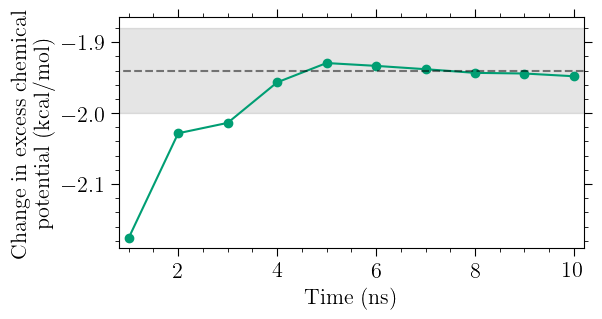

In [11]:
%cd -q $homedir

fig, ax = plt.subplots(figsize=(6,3))

# Data colleciton
slvfes = np.zeros(shape=(max_time, 2, 2, NConfs))
slvfes_err = np.zeros(shape=(max_time, 2, 2, NConfs))
for block in range(max_time):
    for i, native in enumerate(['Water', '1-Octanol']):
        for j, perturbation in enumerate(['P_Water', 'P_1-Octanol']):
            for k in Conf_order:
                b = (block+1) * 1000
                with open('Simulations/Solute-Only_BAR/{}/{}/{}/BAR_result/bar_{}.out'.format(native, perturbation, Conf_order[k], b),
                      'r') as f:
                    lines = f.readlines()
                f.close()
                slvfes[block, i,j,k] = float(lines[-2].split()[5])
                slvfes_err[block, i,j,k] = float(lines[-2].split()[7]) * 1.96 # 95% errors
            
data = unumpy.uarray(slvfes, slvfes_err)

# Determination of octanol-water partitioning free energy by upper, lower, and bar values.
dG_bar = np.zeros(max_time)
dG_bar_err = np.zeros(max_time)

print('Time (ns):\tChange in excess chemical potential (kcal/mol)')

for block in range(max_time):
    # Upper limit
    dG_upper = ((data[block,0,1] - data[block,0,0]).mean()).nominal_value
    
    # Lower limit
    dG_lower = ((data[block,1,1] - data[block,1,0]).mean()).nominal_value
    
    # BAR value
    a = np.stack((slvfes[block,0,0], slvfes[block,0,1]), axis=0)
    b = np.stack((slvfes[block,1,1], slvfes[block,1,0]), axis=0)
    
    a_err = np.stack((slvfes_err[block,0,0], slvfes_err[block,0,1]), axis=0)
    b_err = np.stack((slvfes_err[block,1,1], slvfes_err[block,1,0]), axis=0)
    
    x0 = (dG_upper+dG_lower)/2
    result = optimize.minimize(BAR_solvation_free_energy, x0=x0, args=(a,b))
    
    dG_bar[block] = result.x[0] * RT * kJ_to_kcal
    dG_bar_err[block] = BAR_error_solvation_free_energy(result.x, a, b, a_err, b_err) * kJ_to_kcal
    
    print('{time}:\t\t{slvfe:.2f}±{slvfe_err:.2f}'.format(time=block+1, slvfe=dG_bar[block], slvfe_err=dG_bar_err[block]))
    
ax.plot(range(1,max_time+1), dG_bar, marker='o', color='C2')

ax.hlines(y=-1.94, xmin=0, xmax=21, color='black', alpha=0.5, linestyle='dashed')
ax.fill_between(x=[0,11], y1=[-1.94+0.06,-1.94+0.06], y2=[-1.94-0.06,-1.94-0.06], color='black', alpha=0.1)

ax.set_xlim(0.8, 10.2)
ax.set_xlabel('Time (ns)', fontsize=16)
ax.set_ylabel(f'Change in excess chemical\npotential (kcal/mol)', fontsize=16)
ax.minorticks_on()
ax.locator_params(axis='y', nbins=4)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='both', which='major', labelsize=16, length=6)
ax.tick_params(axis='both', which='minor', labelsize=16, length=3)

fig.savefig('Figures/Solute-only-BAR_simulation_time_convergence.pdf', bbox_inches='tight')

## Step 4: Convergence of Octanol-Water Partitioning Free Energy and Limits with Simulation Time

Time (ns):	Lower (kcal/mol)	BAR (kcal/mol)	Upper (kcal/mol)
1:		-2.25±0.15		-2.18±0.18	-2.09±0.14
2:		-2.23±0.12		-2.03±0.21	-1.84±0.15
3:		-2.21±0.12		-2.01±0.17	-1.83±0.14
4:		-2.09±0.12		-1.96±0.14	-1.82±0.13
5:		-2.06±0.11		-1.93±0.17	-1.80±0.12
6:		-2.06±0.11		-1.93±0.14	-1.80±0.12
7:		-2.05±0.11		-1.94±0.16	-1.82±0.10
8:		-2.04±0.09		-1.94±0.13	-1.84±0.10
9:		-2.06±0.10		-1.94±0.12	-1.82±0.09
10:		-2.06±0.08		-1.95±0.13	-1.83±0.08


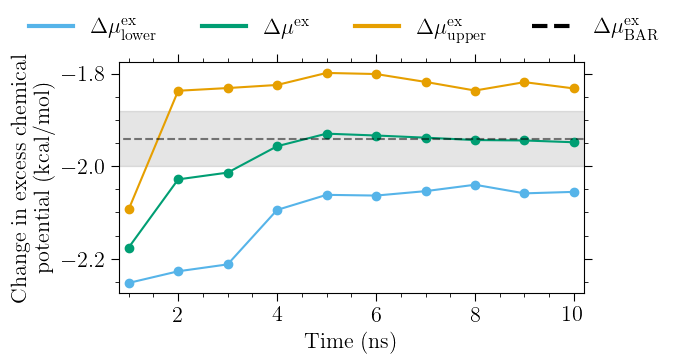

In [12]:
%cd -q $homedir

fig, ax = plt.subplots(figsize=(6,3))

# Data colleciton
slvfes = np.zeros(shape=(max_time, 2, 2, NConfs))
slvfes_err = np.zeros(shape=(max_time, 2, 2, NConfs))
for block in range(max_time):
    for i, native in enumerate(['Water', '1-Octanol']):
        for j, perturbation in enumerate(['P_Water', 'P_1-Octanol']):
            for k in Conf_order:
                b = (block+1) * 1000
                with open('Simulations/Solute-Only_BAR/{}/{}/{}/BAR_result/bar_{}.out'.format(native, perturbation, Conf_order[k], b),
                      'r') as f:
                    lines = f.readlines()
                f.close()
                slvfes[block, i,j,k] = float(lines[-2].split()[5])
                slvfes_err[block, i,j,k] = float(lines[-2].split()[7]) * 1.96 # 95% errors
            
data = unumpy.uarray(slvfes, slvfes_err)

# Determination of octanol-water partitioning free energy by upper, lower, and bar values.
dG_upper = np.zeros(max_time)
dG_upper_err = np.zeros(max_time)
dG_lower = np.zeros(max_time)
dG_lower_err = np.zeros(max_time)
dG_bar = np.zeros(max_time)
dG_bar_err = np.zeros(max_time)

print('Time (ns):\tLower (kcal/mol)\tBAR (kcal/mol)\tUpper (kcal/mol)')

for block in range(max_time):
    # Upper limit
    dG_upper[block] = ((data[block,0,1] - data[block, 0,0]).mean()).nominal_value * kJ_to_kcal
    dG_upper_err[block] = ((data[block,0,1] - data[block,0,0]).mean()).std_dev * kJ_to_kcal
    
    # Lower limit
    dG_lower[block] = ((data[block,1,1] - data[block,1,0]).mean()).nominal_value * kJ_to_kcal
    dG_lower_err[block] = ((data[block,1,1] - data[block,1,0]).mean()).std_dev * kJ_to_kcal
    
    # BAR value
    a = np.stack((slvfes[block,0,0], slvfes[block,0,1]), axis=0)
    b = np.stack((slvfes[block,1,1], slvfes[block,1,0]), axis=0)
    
    a_err = np.stack((slvfes_err[block,0,0], slvfes_err[block,0,1]), axis=0)
    b_err = np.stack((slvfes_err[block,1,1], slvfes_err[block,1,0]), axis=0)
    
    x0 = (dG_upper[block]+dG_lower[block])/2
    result = optimize.minimize(BAR_solvation_free_energy, x0=x0, args=(a,b))
    
    dG_bar[block] = result.x[0] * RT * kJ_to_kcal
    dG_bar_err[block] = BAR_error_solvation_free_energy(result.x, a, b, a_err, b_err) * kJ_to_kcal
    
    print('{time}:\t\t{l:.2f}±{l_err:.2f}\t\t{b:.2f}±{b_err:.2f}\t{u:.2f}±{u_err:.2f}'.format(time=block+1, l=dG_lower[block], l_err=dG_lower_err[block],
                                                                                           b=dG_bar[block], b_err=dG_bar_err[block],
                                                                                           u=dG_upper[block], u_err=dG_upper_err[block]))
    
ax.plot(range(1,max_time+1), dG_upper, marker='o')
ax.plot(range(1,max_time+1), dG_lower, marker='o')
ax.plot(range(1,max_time+1), dG_bar, marker='o')

ax.hlines(y=-1.94, xmin=0, xmax=21, color='black', alpha=0.5, linestyle='dashed')
ax.fill_between(x=[0,11], y1=[-1.94+0.06,-1.94+0.06], y2=[-1.94-0.06,-1.94-0.06], color='black', alpha=0.1)

ax.set_xlim(0.8, 10.2)
ax.set_xlabel('Time (ns)', fontsize=16)
ax.set_ylabel(f'Change in excess chemical\npotential (kcal/mol)', fontsize=16)
ax.minorticks_on()
ax.locator_params(axis='y', nbins=4)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='both', which='major', labelsize=16, length=6)
ax.tick_params(axis='both', which='minor', labelsize=16, length=3)

lower_patch = Line2D([], [], color='C1',    lw=3, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{lower}}$')
BAR_patch   = Line2D([], [], color='C2',    lw=3, label='$\Delta\mu^{\mathrm{ex}}$')
upper_patch = Line2D([], [], color='C0',    lw=3, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{upper}}$')
REF_patch   = Line2D([], [], color='black', lw=3, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{BAR}}$', linestyle='dashed')

fig.legend(handles=[lower_patch, BAR_patch, upper_patch, REF_patch], loc='lower center', ncol=4, fontsize=16,
           bbox_to_anchor=(0.5, 0.88), frameon=False)

fig.savefig('Figures/Solute-only-BAR_simulation_time_convergence_with_limits.pdf', bbox_inches='tight')

## Step 5: Convergence of Octanol-Water Partitioning Free Energy with Number of Solute Structures

Number of structues:	Change in excess chemical potential (kcal/mol)
1:			-2.21±0.28
2:			-2.01±0.18
3:			-2.07±0.16
4:			-1.97±0.12
5:			-1.94±0.15
6:			-1.98±0.14
7:			-1.90±0.21
8:			-1.85±0.19
9:			-1.87±0.18
10:			-1.89±0.17
11:			-1.90±0.17
12:			-1.93±0.16
13:			-1.93±0.16
14:			-1.95±0.15
15:			-1.93±0.14
16:			-1.93±0.14
17:			-1.93±0.14
18:			-1.94±0.13
19:			-1.94±0.13
20:			-1.95±0.13

Block averaging: -1.95±0.01 kcal/mol


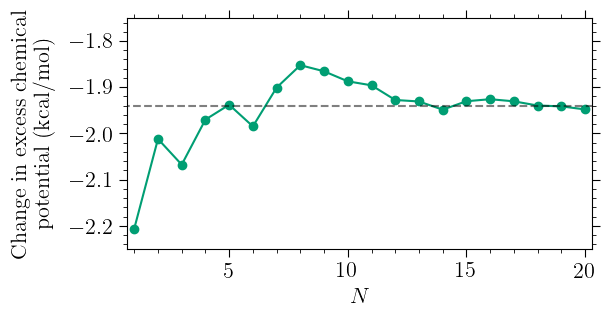

In [13]:
%cd -q $homedir

fig, ax = plt.subplots(figsize=(6,3))

# Data colleciton
slvfes = np.zeros(shape=(2, 2, NConfs))
slvfes_err = np.zeros(shape=(2, 2, NConfs))
for i, native in enumerate(['Water', '1-Octanol']):
    for j, perturbation in enumerate(['P_Water', 'P_1-Octanol']):
        for k in Conf_order:
            time = max_time * 1000
            with open('Simulations/Solute-Only_BAR/{}/{}/{}/BAR_result/bar_{}.out'.format(native, perturbation, Conf_order[k], time),
                      'r') as f:
                    lines = f.readlines()
            f.close()
            slvfes[i,j,k] = float(lines[-2].split()[5])
            slvfes_err[i,j,k] = float(lines[-2].split()[7]) * 1.96 # 95% errors
            
data = unumpy.uarray(slvfes, slvfes_err)

# Determination of octanol-water partitioning free energy by upper, lower, and bar values.
dG_bar = np.zeros(NConfs)
dG_bar_err = np.zeros(NConfs)

print('Number of structues:\tChange in excess chemical potential (kcal/mol)')

for N_confs in range(1,NConfs+1):
    # Upper limit
    dG_upper = ((data[0,1,:N_confs] - data[0,0,:N_confs]).mean()).nominal_value
    
    # Lower limit
    dG_lower = ((data[1,1,:N_confs] - data[1,0,:N_confs]).mean()).nominal_value
    
    # BAR value
    a = np.stack((slvfes[0,0,:N_confs], slvfes[0,1,:N_confs]), axis=0)
    b = np.stack((slvfes[1,1,:N_confs], slvfes[1,0,:N_confs]), axis=0)
    
    a_err = np.stack((slvfes_err[0,0,:N_confs], slvfes_err[0,1,:N_confs]), axis=0)
    b_err = np.stack((slvfes_err[1,1,:N_confs], slvfes_err[1,0,:N_confs]), axis=0)
    
    x0 = (dG_upper+dG_lower)/2
    result = optimize.minimize(BAR_solvation_free_energy, x0=x0, args=(a,b))
    
    dG_bar[N_confs-1] = result.x[0] * RT * kJ_to_kcal
    dG_bar_err[N_confs-1] = BAR_error_solvation_free_energy(result.x, a, b, a_err, b_err) * kJ_to_kcal
    
    print('{Nstructures}:\t\t\t{slvfe:.2f}±{slvfe_err:.2f}'.format(Nstructures=N_confs, slvfe=dG_bar[N_confs-1], slvfe_err=dG_bar_err[N_confs-1]))

x = range(1, len(Conf_order)+1)
ax.plot(x, dG_bar, marker='o', color='C2')
ax.hlines(y=-1.94, xmin=0, xmax=21, color='black', alpha=0.5, linestyle='dashed')

dG_bar_blocks = dG_bar.reshape(5,4)
print('\nBlock averaging: {:.2f}±{:.2f} kcal/mol'.format(dG_bar_blocks.mean(axis=0).mean(),
                                                         dG_bar_blocks.mean(axis=0).std() / np.sqrt(4)))

ax.set_xlabel('$N$', fontsize=16)
ax.set_ylabel(f'Change in excess chemical\npotential (kcal/mol)', fontsize=16, labelpad=10)
ax.minorticks_on()
ax.set_xticks(ticks=np.arange(1,21), minor=True)
ax.set_xticks(ticks=np.arange(5,21, 5), minor=False)
ax.set_yticks(ticks=np.arange(-2.3, -1.7, 0.02), minor=True)
ax.set_yticks(ticks=np.arange(-2.3, -1.7, 0.1), minor=False)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='both', which='major', labelsize=16, length=6)
ax.tick_params(axis='both', which='minor', labelsize=16, length=3)
ax.set_xlim(0.7, 20.3)
ax.set_ylim(-2.25, -1.75)

fig.savefig('Figures/Solute-only-BAR_solute_structure_convergence.pdf', bbox_inches='tight')

In [14]:
def BAR_solvation_free_energy_v2(D, dSLVFE_AB, dSLVFE_BA, T=298.15, R=0.00831446261815324):
    RT = R * T
    
    # Initializing sum of Fermi-Dirac functions
    sum_f_ij = 0
    sum_f_ji = 0
    
    # Adding Fermi-Dirac function for each slvfe
    for dSLVFE in dSLVFE_AB:
        sum_f_ij += 1/(1+np.exp(-dSLVFE/RT+D))
    for dSLVFE in dSLVFE_BA:
        sum_f_ji += 1/(1+np.exp(dSLVFE/RT-D))
        
    # return squared diff. btw sums of Fermi-Dirac functions
    return (sum_f_ij - sum_f_ji)**2

N_bootstrap = 1000

upper = unumpy.nominal_values((data[0,1] - data[0,0]))
lower = unumpy.nominal_values((data[1,1] - data[1,0]))

lower_bootstrap = np.random.choice(lower, size=(N_bootstrap, len(lower)), replace=True)
upper_bootstrap = np.random.choice(upper, size=(N_bootstrap, len(upper)), replace=True)

bar_bootstraps_values = np.zeros(N_bootstrap)
# BAR
for l, (a, b) in enumerate(zip(lower_bootstrap, upper_bootstrap)):
    initial_guess = (a.mean()+b.mean())/2
    result = optimize.minimize(BAR_solvation_free_energy_v2, x0=initial_guess, args=(a,b,298.15))
    bar_bootstraps_values[l] = result.x[0]*RT*kJ_to_kcal
    
print('Bootstrap 95% standard error: {:.4f} kcal/mol'.format(np.std(bar_bootstraps_values)))

Bootstrap 95% standard error: 0.0516 kcal/mol


## Step 6: Convergence of Octanol-Water Partitioning Free Energy and Limits with Number of Solute Structures

Number of Conf:	Lower (kcal/mol)	BAR (kcal/mol)	Upper (kcal/mol)
1:		-2.39±0.30		-2.21±0.28	-2.03±0.34
2:		-2.09±0.21		-2.01±0.18	-1.94±0.24
3:		-2.16±0.16		-2.07±0.16	-1.98±0.22
4:		-2.00±0.13		-1.97±0.12	-1.94±0.18
5:		-2.03±0.14		-1.94±0.15	-1.85±0.16
6:		-2.11±0.15		-1.98±0.14	-1.86±0.15
7:		-1.93±0.13		-1.90±0.21	-1.85±0.13
8:		-1.89±0.12		-1.85±0.19	-1.80±0.12
9:		-1.93±0.12		-1.87±0.18	-1.78±0.11
10:		-1.96±0.11		-1.89±0.17	-1.80±0.11
11:		-1.95±0.10		-1.90±0.17	-1.82±0.10
12:		-2.01±0.09		-1.93±0.16	-1.83±0.09
13:		-1.99±0.09		-1.93±0.16	-1.86±0.09
14:		-2.01±0.10		-1.95±0.15	-1.88±0.09
15:		-2.00±0.09		-1.93±0.14	-1.85±0.09
16:		-2.01±0.09		-1.93±0.14	-1.83±0.09
17:		-2.03±0.09		-1.93±0.14	-1.82±0.09
18:		-2.03±0.09		-1.94±0.13	-1.84±0.09
19:		-2.05±0.09		-1.94±0.13	-1.83±0.08
20:		-2.06±0.08		-1.95±0.13	-1.83±0.08


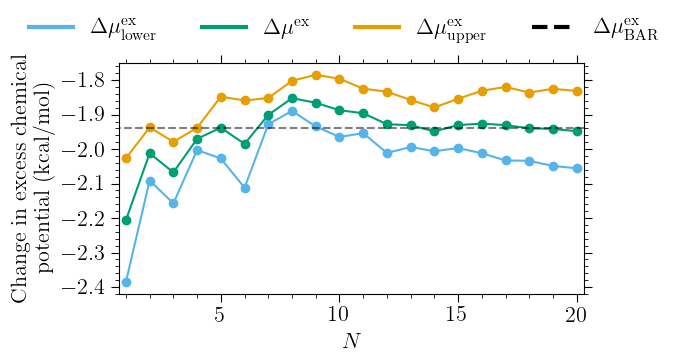

In [15]:
%cd -q $homedir

fig, ax = plt.subplots(figsize=(6,3))

# Data colleciton
slvfes = np.zeros(shape=(2, 2, NConfs))
slvfes_err = np.zeros(shape=(2, 2, NConfs))
for i, native in enumerate(['Water', '1-Octanol']):
    for j, perturbation in enumerate(['P_Water', 'P_1-Octanol']):
        for k in Conf_order:
            time = max_time * 1000
            with open('Simulations/Solute-Only_BAR/{}/{}/{}/BAR_result/bar_{}.out'.format(native, perturbation, Conf_order[k], time),
                      'r') as f:
                    lines = f.readlines()
            f.close()
            slvfes[i,j,k] = float(lines[-2].split()[5])
            slvfes_err[i,j,k] = float(lines[-2].split()[7]) * 1.96 # 95% errors
            
data = unumpy.uarray(slvfes, slvfes_err)

# Determination of octanol-water partitioning free energy by upper, lower, and bar values.
dG_upper = np.zeros(NConfs)
dG_upper_err = np.zeros(NConfs)
dG_lower = np.zeros(NConfs)
dG_lower_err = np.zeros(NConfs)
dG_bar = np.zeros(NConfs)
dG_bar_err = np.zeros(NConfs)

print('Number of Conf:\tLower (kcal/mol)\tBAR (kcal/mol)\tUpper (kcal/mol)')

for N_confs in range(1,NConfs+1):
    # Upper limit
    dG_upper[N_confs-1] = ((data[0,1,:N_confs] - data[0,0,:N_confs]).mean()).nominal_value * kJ_to_kcal
    dG_upper_err[N_confs-1] = ((data[0,1,:N_confs] - data[0,0,:N_confs]).mean()).std_dev * kJ_to_kcal
    
    # Lower limit
    dG_lower[N_confs-1] = ((data[1,1,:N_confs] - data[1,0,:N_confs]).mean()).nominal_value * kJ_to_kcal
    dG_lower_err[N_confs-1] = ((data[1,1,:N_confs] - data[1,0,:N_confs]).mean()).std_dev * kJ_to_kcal
    
    # BAR value
    a = np.stack((slvfes[0,0,:N_confs], slvfes[0,1,:N_confs]), axis=0)
    b = np.stack((slvfes[1,1,:N_confs], slvfes[1,0,:N_confs]), axis=0)
    
    a_err = np.stack((slvfes_err[0,0,:N_confs], slvfes_err[0,1,:N_confs]), axis=0)
    b_err = np.stack((slvfes_err[1,1,:N_confs], slvfes_err[1,0,:N_confs]), axis=0)
    
    x0 = (dG_upper[N_confs-1]+dG_lower[N_confs-1])/2
    result = optimize.minimize(BAR_solvation_free_energy, x0=x0, args=(a,b))
    
    dG_bar[N_confs-1] = result.x[0] * RT * kJ_to_kcal
    dG_bar_err[N_confs-1] = BAR_error_solvation_free_energy(result.x, a, b, a_err, b_err) * kJ_to_kcal
    
    print('{Nstructures}:\t\t{l:.2f}±{l_err:.2f}\t\t{b:.2f}±{b_err:.2f}\t{u:.2f}±{u_err:.2f}'.format(Nstructures=N_confs, l=dG_lower[N_confs-1], l_err=dG_lower_err[N_confs-1],
                                                                                              b=dG_bar[N_confs-1], b_err=dG_bar_err[N_confs-1],
                                                                                              u=dG_upper[N_confs-1], u_err=dG_upper_err[N_confs-1]))
    

x = range(1, NConfs+1)
ax.plot(x, dG_upper, marker='o', color='C0')
ax.plot(x, dG_lower, marker='o', color='C1')
ax.plot(x, dG_bar, marker='o', color='C2')

ax.hlines(y=-1.94, xmin=0, xmax=21, color='black', alpha=0.5, linestyle='dashed')

ax.set_xlabel('$N$', fontsize=16)
ax.set_ylabel(f'Change in excess chemical\npotential (kcal/mol)', fontsize=16)
ax.minorticks_on()
ax.set_xticks(ticks=np.arange(1,21), minor=True)
ax.set_xticks(ticks=np.arange(5,21, 5), minor=False)
ax.set_yticks(ticks=np.arange(-2.5, -1.7, 0.02), minor=True)
ax.set_yticks(ticks=np.arange(-2.5, -1.7, 0.1), minor=False)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='both', which='major', labelsize=16, length=6)
ax.tick_params(axis='both', which='minor', labelsize=16, length=3)
ax.set_xlim(0.7, 20.3)
ax.set_ylim(-2.42, -1.75)

lower_patch = Line2D([], [], color='C1',    lw=3, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{lower}}$')
BAR_patch   = Line2D([], [], color='C2',    lw=3, label='$\Delta\mu^{\mathrm{ex}}$')
upper_patch = Line2D([], [], color='C0',    lw=3, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{upper}}$')
REF_patch   = Line2D([], [], color='black', lw=3, label='$\Delta\mu^{\mathrm{ex}}_{\mathrm{BAR}}$', linestyle='dashed')

fig.legend(handles=[lower_patch, BAR_patch, upper_patch, REF_patch], loc='lower center', ncol=4, fontsize=16,
           bbox_to_anchor=(0.5, 0.88), frameon=False)

fig.savefig('Figures/Solute-only-BAR_solute_structure_convergence_with_limits.pdf', bbox_inches='tight')

## Step 7: Individual Values of Changes in Free Energy for the Different Structures

In [16]:
## Data colleciton
slvfes = np.zeros(shape=(2, 2, NConfs))
slvfes_err = np.zeros(shape=(2, 2, NConfs))
for i, native in enumerate(['Water', '1-Octanol']):
    for j, perturbation in enumerate(['P_Water', 'P_1-Octanol']):
        for k in Conf_order:
            time = max_time * 1000
            with open('Simulations/Solute-Only_BAR/{}/{}/{}/BAR_result/bar_{}.out'.format(native, perturbation, Conf_order[k], time),
                      'r') as f:
                    lines = f.readlines()
            f.close()
            slvfes[i,j,k] = float(lines[-2].split()[5]) * kJ_to_kcal
            slvfes_err[i,j,k] = float(lines[-2].split()[7]) * kJ_to_kcal * 1.96 # 95% errors

data = unumpy.uarray(slvfes, slvfes_err)
# Determination of octanol-water partitioning free energy by upper, lower, and bar values.
print(f'index:\tdG (water) [kcal/mol]\tdG (octanol) [kcal/mol]')
for idx, (i,j) in enumerate(zip((data[0,1]-data[0,0]),(data[1,1]-data[1,0]))):
    print('{}:\t{:.2f}\t\t{:.2f}'.format(idx+1,i,j))

index:	dG (water) [kcal/mol]	dG (octanol) [kcal/mol]
1:	-2.03+/-0.34		-2.39+/-0.30
2:	-1.85+/-0.33		-1.80+/-0.30
3:	-2.06+/-0.46		-2.29+/-0.24
4:	-1.82+/-0.31		-1.54+/-0.21
5:	-1.49+/-0.38		-2.12+/-0.48
6:	-1.91+/-0.36		-2.54+/-0.51
7:	-1.81+/-0.18		-0.82+/-0.34
8:	-1.45+/-0.26		-1.62+/-0.21
9:	-1.64+/-0.35		-2.29+/-0.40
10:	-1.90+/-0.34		-2.24+/-0.15
11:	-2.11+/-0.11		-1.84+/-0.36
12:	-1.93+/-0.34		-2.64+/-0.21
13:	-2.15+/-0.31		-1.79+/-0.39
14:	-2.16+/-0.49		-2.17+/-0.65
15:	-1.50+/-0.27		-1.87+/-0.17
16:	-1.48+/-0.73		-2.23+/-0.28
17:	-1.64+/-0.35		-2.37+/-0.61
18:	-2.11+/-0.23		-2.05+/-0.46
19:	-1.63+/-0.41		-2.32+/-0.40
20:	-1.95+/-0.37		-2.18+/-0.32


## Step 8: Solute Structure and Solvent Structure Convergence

In [17]:
# Data colleciton
slvfes = np.zeros(shape=(2, 2, NConfs, 20))
slvfes_err = np.zeros(shape=(2, 2, NConfs, 20))
for i, native in enumerate(['Water', '1-Octanol']):
    for j, perturbation in enumerate(['P_Water', 'P_1-Octanol']):
        for k in Conf_order:
            for l in range(20):
                time = (l+1) * 1000
                with open('Simulations/Solute-Only_BAR/{}/{}/{}/BAR_result/bar_{}.out'.format(native, perturbation, Conf_order[k], time),
                          'r') as f:
                        lines = f.readlines()
                f.close()  
                slvfes[i,j,k,l] = float(lines[-2].split()[5])
                slvfes_err[i,j,k,l] = float(lines[-2].split()[7]) * 1.96 # 95% errors
                
data = unumpy.uarray(slvfes, slvfes_err)

print('Change in Chemical Potential and Solvent 95% Errors (kcal/mol)')
print('MD time (ns)\t    N=5\t\t    N=10\t    N=15\t    N=20')
for time in range(20):
    results = []
    for N_confs in np.arange(5,NConfs+1,5):
        # Upper limit
        dG_upper = ((data[0,1,:N_confs,time] - data[0,0,:N_confs,time]).mean()).nominal_value * kJ_to_kcal
        
        # Lower limit
        dG_lower = ((data[1,1,:N_confs,time] - data[1,0,:N_confs,time]).mean()).nominal_value * kJ_to_kcal
        
        # BAR value
        a = np.stack((slvfes[0,0,:N_confs,time], slvfes[0,1,:N_confs,time]), axis=0)
        b = np.stack((slvfes[1,1,:N_confs,time], slvfes[1,0,:N_confs,time]), axis=0)
        
        a_err = np.stack((slvfes_err[0,0,:N_confs,time], slvfes_err[0,1,:N_confs,time]), axis=0)
        b_err = np.stack((slvfes_err[1,1,:N_confs,time], slvfes_err[1,0,:N_confs,time]), axis=0)
        
        x0 = (dG_upper+dG_lower)/2
        result = optimize.minimize(BAR_solvation_free_energy, x0=x0, args=(a,b))
        
        dG_bar = result.x[0] * RT * kJ_to_kcal
        dG_bar_err = BAR_error_solvation_free_energy(result.x, a, b, a_err, b_err) * kJ_to_kcal
        
        results.append('{:.2f}±{:.2f}'.format(dG_bar, dG_bar_err))
    print('{}\t\t{}\t{}\t{}\t{}'.format(time+1, *results))

Change in Chemical Potential and Solvent 95% Errors (kcal/mol)
MD time (ns)	    N=5		    N=10	    N=15	    N=20
1		-2.15±0.36	-2.11±0.27	-2.18±0.21	-2.18±0.18
2		-1.92±0.52	-1.96±0.30	-1.98±0.26	-2.03±0.21
3		-1.88±0.36	-1.96±0.24	-2.00±0.20	-2.01±0.17
4		-1.87±0.23	-1.90±0.19	-1.95±0.16	-1.96±0.14
5		-1.88±0.21	-1.89±0.25	-1.92±0.20	-1.93±0.17
6		-1.95±0.21	-1.90±0.18	-1.93±0.15	-1.93±0.14
7		-1.95±0.20	-1.89±0.23	-1.93±0.19	-1.94±0.16
8		-1.94±0.22	-1.88±0.16	-1.93±0.13	-1.94±0.13
9		-1.94±0.17	-1.88±0.16	-1.93±0.13	-1.94±0.12
10		-1.94±0.15	-1.89±0.17	-1.93±0.14	-1.95±0.13
11		-1.95±0.19	-1.89±0.20	-1.93±0.17	-1.95±0.15
12		-1.96±0.10	-1.89±0.12	-1.92±0.10	-1.93±0.09
13		-1.95±0.15	-1.89±0.19	-1.91±0.15	-1.93±0.13
14		-1.97±0.16	-1.89±0.22	-1.91±0.17	-1.93±0.15
15		-1.95±0.15	-1.88±0.21	-1.89±0.17	-1.92±0.15
16		-1.94±0.12	-1.88±0.19	-1.90±0.15	-1.92±0.13
17		-1.94±0.12	-1.88±0.12	-1.89±0.10	-1.92±0.09
18		-1.94±0.11	-1.88±0.15	-1.89±0.12	-1.93±0.10
19		-1.94±0.10	-1.89±0.18	-1.89±0

## Step 9: Evaluation of *n*-hexanol Structural Ensemble and Structures Utilized

In [18]:
%cd -q $homedir

traj_octanol = md.load('Simulations/Solute-Only_BAR/1-Octanol/Solute/BAR.xtc',
                       top='Simulations/Solute-Only_BAR/1-Octanol/Solute/BAR.gro')

traj_water = md.load('Simulations/Solute-Only_BAR/Water/Solute/BAR.xtc',
                     top='Simulations/Solute-Only_BAR/Water/Solute/BAR.gro')

hexanol_indices = traj_octanol.topology.select('resname "HEX"')

for traj in [traj_octanol, traj_water]:
    traj.atom_slice(hexanol_indices, inplace=True)

### Principal Component Analysis Based on Heavy Atom Distances

/tmp/ipykernel_47107/3577968452.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(h_pad=5, w_pad=3)


Explained variance by PC1: 23.79%
Explained variance by PC2: 14.39%


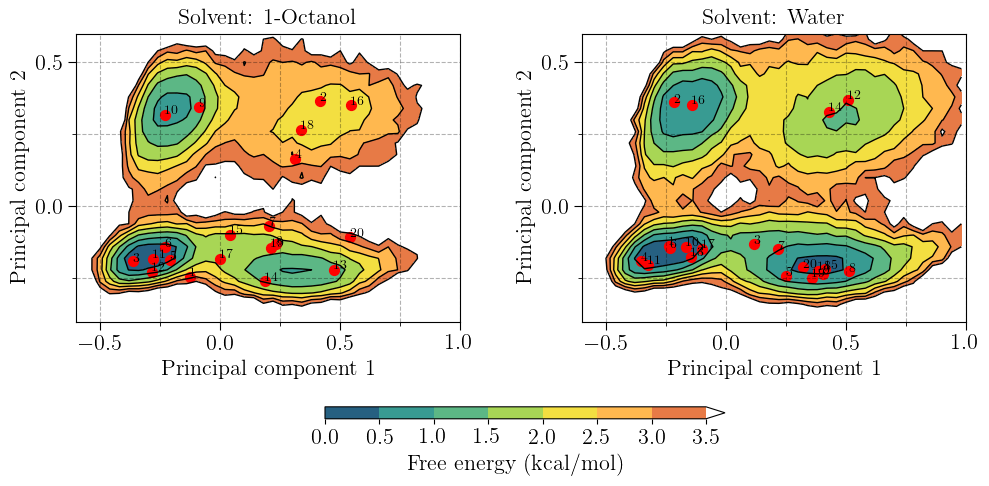

In [19]:
heavy_atom_pairs = traj_octanol.topology.select_pairs('not element hydrogen', 'not element hydrogen')
pairwise_distances = md.geometry.compute_distances(traj_octanol+traj_water, heavy_atom_pairs)

pca = PCA(n_components=2)
reduced_distances = pca.fit_transform(pairwise_distances)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

titles = [f'Solvent: 1-Octanol', f'Solvent: Water',]

for i, ax in enumerate(axes):
    j = i * traj_octanol.n_frames
    k = j + traj_octanol.n_frames
    free_energies = get_2D_PMF(reduced_distances[j:k, 0],
                               reduced_distances[j:k, 1],
                               nbins=50, ranges=((-1, 1), (-1, 1)), kT=0.5925)
    
    lines = ax.contour(free_energies[0], free_energies[1], free_energies[2],
                       levels=np.arange(0,4.0,0.5), linewidths=1, colors='k')
    
    fill = ax.contourf(free_energies[0], free_energies[1], free_energies[2],
                       cmap='fessa', extend='max', levels=np.arange(0,4.0,0.5))
    
    points = ax.scatter(reduced_distances[j:k, 0][1:][::traj_octanol.n_frames//NConfs_sim][0:NConfs],
                        reduced_distances[j:k, 1][1:][::traj_octanol.n_frames//NConfs_sim][0:NConfs],
                        s=50, color='red')
    
    for idx in range(1, NConfs+1):
        texts = ax.text(reduced_distances[j:k, 0][1:][::traj_octanol.n_frames//NConfs_sim][0:NConfs][idx-1],
                        reduced_distances[j:k, 1][1:][::traj_octanol.n_frames//NConfs_sim][0:NConfs][idx-1],
                        idx, fontsize=10)
    
    cmap = fill.get_cmap()
    cmap.set_over('white')
    fill.set_cmap(cmap)
    ax.minorticks_on()
    ax.set_title(titles[i], fontsize=16)
    ax.set_xlabel('Principal component 1', fontsize=16)
    ax.set_ylabel('Principal component 2', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=16, length=3)
    ax.set_xticks(ticks=[-0.5, 0.0, 0.5, 1.0], minor=False)
    ax.set_xticks(ticks=[-0.25, 0.25, 0.75], minor=True)
    ax.set_yticks(ticks=[-0.5, 0.0, 0.5], minor=False)
    ax.set_yticks(ticks=[-0.75, -0.25, 0.25, 0.75], minor=True)
    ax.grid(linestyle='--', color='black', alpha=0.3, which='both')
    ax.set_xlim(-0.6, 1.0)
    ax.set_ylim(-0.4, 0.6)
    
cbar_ax = fig.add_axes([0.33, -0.06, 0.4, 0.03])
cbar = fig.colorbar(fill, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_title('Free energy (kcal/mol)', y=-5, fontsize=16, loc='center')
    
fig.tight_layout(h_pad=5, w_pad=3)

print('Explained variance by PC1: {:.2f}%'.format(pca.explained_variance_ratio_[0]*100))
print('Explained variance by PC2: {:.2f}%'.format(pca.explained_variance_ratio_[1]*100))
fig.savefig('Figures/Solute-only-BAR_PCA_space.pdf', bbox_inches='tight')